In [1]:
import librosa
import numpy as np

In [2]:
def load_wav_16k(filename):
    wav, sr = librosa.load(filename, sr=16000, mono=True)
    return wav

In [3]:
wave = load_wav_16k("../DroneAudioDataset/Binary_Drone_Audio/yes_drone/B_S2_D1_067-bebop_000_.wav")

In [4]:
import matplotlib.pyplot as plt
import os

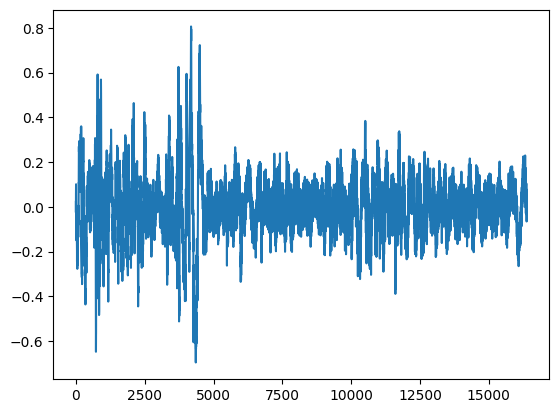

In [5]:
plt.plot(wave)

In [6]:
drone_dataset_dir="../DroneAudioDataset/Binary_Drone_Audio/yes_drone"
unknown_dataset_dir="../DroneAudioDataset/Binary_Drone_Audio/unknown"

In [8]:
drone_durations=[]
unknown_durations=[]
for file in os.listdir(drone_dataset_dir):
    if file.endswith(".wav"):
        drone_file_path = os.path.join(drone_dataset_dir, file)
        drone_wav, sr = librosa.load(drone_file_path, sr=16000, mono=True)
        drone_duration = librosa.get_duration(y=drone_wav, sr=sr)
        drone_durations.append(drone_duration)
for file in os.listdir(unknown_dataset_dir):
    if file.endswith(".wav"):
        unk_file_path = os.path.join(unknown_dataset_dir, file)
        unk_wav, sr = librosa.load(unk_file_path, sr=16000, mono=True)
        unknown_duration = librosa.get_duration(y=unk_wav, sr=sr)
        unknown_durations.append(unknown_duration)
        
drone_durations= np.array(drone_durations)
unknown_durations= np.array(unknown_durations)

print(f"Drone Total files: {len(drone_durations)}")
print(f"Drone Min duration: {drone_durations.min():.2f} sec")
print(f"Drone Max duration: {drone_durations.max():.2f} sec")
print(f"Drone Mean duration: {drone_durations.mean():.2f} sec")

print(f"Unknown Total files: {len(unknown_durations)}")
print(f"Unknown Min duration: {unknown_durations.min():.2f} sec")
print(f"Unknown Max duration: {unknown_durations.max():.2f} sec")
print(f"Unknown Mean duration: {unknown_durations.mean():.2f} sec")

Drone Total files: 1332
Drone Min duration: 0.65 sec
Drone Max duration: 1.02 sec
Drone Mean duration: 1.00 sec
Unknown Total files: 10372
Unknown Min duration: 0.00 sec
Unknown Max duration: 5.12 sec
Unknown Mean duration: 1.03 sec


In [9]:
desired_duration = 1.0
    

In [14]:
drone_audio_dataset = []
unknown_audio_dataset = []
SAMPLE_RATE = 16000

def padding(wav, desired_duration_sec):
    desired_length = int(SAMPLE_RATE * desired_duration_sec)  # convert to number of samples
    current_length = len(wav)

    if current_length > desired_length:
        wav = wav[:desired_length]
    else:
        padding_zeroes = np.zeros(desired_length - current_length)
        wav = np.concatenate((wav, padding_zeroes))

    return wav
    
for file in os.listdir(drone_dataset_dir):
    if file.endswith(".wav"):
        wav = load_wav_16k(os.path.join(drone_dataset_dir,file))
        wav = padding(wav,desired_duration)
        drone_audio_dataset.append(wav)

drone_audio_dataset=np.array(drone_audio_dataset)

for file in os.listdir(unknown_dataset_dir):
    if file.endswith(".wav"):
        wav = load_wav_16k(os.path.join(unknown_dataset_dir,file))
        wav = padding(wav,desired_duration)
        unknown_audio_dataset.append(wav)

unknown_audio_dataset=np.array(unknown_audio_dataset)

In [15]:
print("Shape:", drone_audio_dataset.shape)  # Should be (num_files, 48000)
print("Shape:", unknown_audio_dataset.shape)

Shape: (1332, 16000)
Shape: (10372, 16000)


In [16]:
import librosa.display

In [17]:
def compute_mel_spectrogram(wav, sample_rate=16000, n_mels=64):
    mel_spect = librosa.feature.melspectrogram(y=wav,sr=sample_rate,n_fft=1024,hop_length=512,n_mels=n_mels)

    #conver to log scale (db)
    mel_spect_db = librosa.power_to_db(mel_spect, ref = np.max)
    return mel_spect_db

In [18]:
drone_spectrogram_dataset=[]
unknown_spectrogram_dataset=[]

for wav in drone_audio_dataset:
    drone_spectrogram_dataset.append(compute_mel_spectrogram(wav))
for wav in unknown_audio_dataset:
    unknown_spectrogram_dataset.append(compute_mel_spectrogram(wav))

drone_spectrogram_dataset = np.array(drone_spectrogram_dataset)
unknown_spectrogram_dataset = np.array(unknown_spectrogram_dataset)

print("Drone Spectrogram dataset shape:", drone_spectrogram_dataset.shape) 
print("Unknown Spectrogram dataset shape:", unknown_spectrogram_dataset.shape) 

Drone Spectrogram dataset shape: (1332, 64, 32)
Unknown Spectrogram dataset shape: (10372, 64, 32)


In [ ]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(drone_spectrogram_dataset[1], sr=16000, x_axis='time', y_axis='mel')
plt.title('Drone Mel Spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()


In [ ]:
plt.figure(figsize=(10, 4))
for i in range(len(unknown_spectrogram_dataset)-10000):
    librosa.display.specshow(unknown_spectrogram_dataset[i], sr=16000, x_axis='time', y_axis='mel')
    plt.title('Unknown Random Mel Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [22]:
from sklearn.model_selection import train_test_split

In [30]:
import numpy as np

# Adjust this if you're downsampling the unknown dataset
drone_data = drone_spectrogram_dataset
unknown_data = unknown_spectrogram_dataset[:len(drone_data)]

# Create labels
drone_labels = np.ones(len(drone_data))         # Label 1 for drone
unknown_labels = np.zeros(len(unknown_data))    # Label 0 for unknown

# Combine
X = np.concatenate((drone_data, unknown_data), axis=0)
y = np.concatenate((drone_labels, unknown_labels), axis=0)

# Save arrays
np.save("X_spectrogram.npy", X)
np.save("y_labels.npy", y)

print("✅ Saved X_spectrogram.npy and y_labels.npy")


✅ Saved X_spectrogram.npy and y_labels.npy
